# 데이터와 필터의 포맷

싸이킷런에 내장되어 있는 중국 이화원의 불향각 사진을 불러오겠습니다.  
427$\times$640 해상도의 컬러사진이고 H$\times$W$\times$C 포맷을 따릅니다.

C:\Users\user\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


(427, 640, 3)


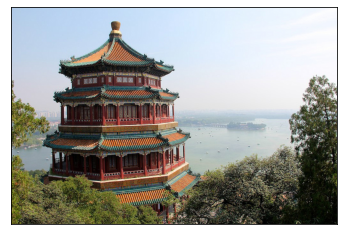

In [ ]:
from sklearn.datasets import load_sample_image
import matplotlib.pyplot as plt

china = load_sample_image('china.jpg')/255
print(china.shape)

plt.imshow(china)
plt.xticks([])
plt.yticks([])
plt.show()

역시 싸이킷런에 내장되어 있는 동일 해상도의 데이지 사진을 불러오겠습니다.

(427, 640, 3)


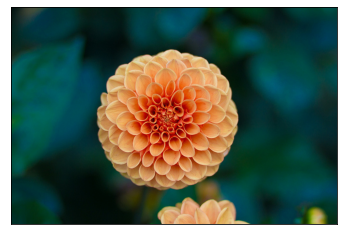

In [ ]:
flower = load_sample_image('flower.jpg')/255
print(flower.shape)

plt.imshow(flower)
plt.xticks([])
plt.yticks([])
plt.show()

**[실습1] 데이지 사진을 RGB 채널별로 각각 분리해서 출력하시오.**

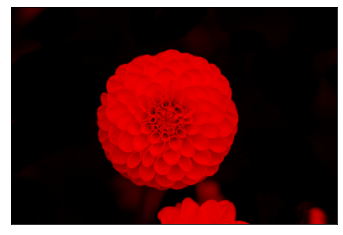

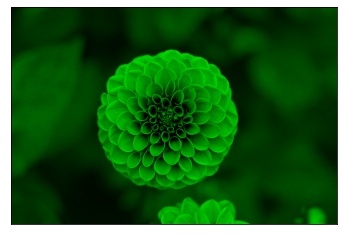

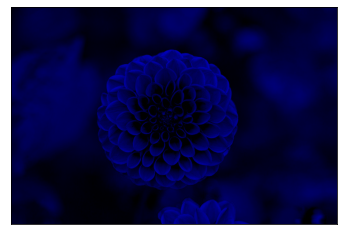

In [ ]:
flower_red = flower.copy()
flower_green = flower.copy()
flower_blue = flower.copy()

flower_red[:,:,1:]=0
plt.imshow(flower_red)
plt.xticks([])
plt.yticks([])
plt.show()

flower_green[:,:,0]=0
flower_green[:,:,2]=0
plt.imshow(flower_green)
plt.xticks([])
plt.yticks([])
plt.show()

flower_blue[:,:,:2]=0
plt.imshow(flower_blue)
plt.xticks([])
plt.yticks([])
plt.show()

N$\times$H$\times$W$\times$C 포맷으로 두 사진을 묶겠습니다.  
밑바닥부터 시작하는 딥러닝에서는 데이터가 N$\times$C$\times$H$\times$W 포맷을 따랐지만 케라스에서는 N$\times$H$\times$W$\times$C 포맷을 따릅니다.  

In [ ]:
import numpy as np

images = np.array([china,flower])
print(images.shape)

(2, 427, 640, 3)


이전에 다뤘던 수평 Sobel필터 $\begin{pmatrix}1&2&1\\0&0&0\\-1&-2&-1\end{pmatrix}$와 수직 Sobel필터 $\begin{pmatrix}1&0&-1\\2&0&-2\\1&0&-1\end{pmatrix}$입니다.  
수평 Sobel필터는 수평 경계선을, 수직 Sobel필터는 수직 경계선을 찾아냅니다.  
RGB채널별로 찾아 내기 위해 동일한 필터 3개를 각각 묶습니다.  
그리고, 그 두 묶음을 다시 묶습니다.  
그러면, FN$\times$C$\times$FH$\times$FW 포맷이 됩니다.  
밑바닥부터 시작하는 딥러닝에서는 필터가 FN$\times$C$\times$FH$\times$FW 포맷을 따랐지만 케라스에서는 FH$\times$FW$\times$C$\times$FN 포맷을 따릅니다.  
이전에 배운 transpose를 이용하여 축의 위치를 바꿔줍니다.

In [ ]:
filter_h = [[1.,2.,1.],[0.,0.,0.],[-1.,-2.,-1.]]
filters_h = np.array([filter_h,filter_h,filter_h])

filter_v = np.array([[1.,0.,-1.],[2.,0.,-2.],[1.,0.,-1.]])
filters_v = np.array([filter_v,filter_v,filter_v])

filters = np.array([filters_h, filters_v])
print(filters.shape)

filters = filters.transpose(2,3,1,0)
print(filters.shape)

(2, 3, 3, 3)
(3, 3, 3, 2)


# 합성곱

텐서플로우에는 층들이 [tf.keras.layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers)와 [tf.nn](https://www.tensorflow.org/api_docs/python/tf/nn)에 구현되어 있습니다.  
내용적으로는 비슷하지만 입력 인수가 다릅니다.  
tf.keras.layers가 좀 더 사용하기 편하고 tf.nn은 좀 더 유연해서 커스텀 모델에 사용되는 경향이 있습니다.  
합성곱층도 함수 [tf.nn.conv2d](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d)와 클래스 [tf.keras.layers.Conv2d](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)로 구현되어 있습니다.  
실험에 더 적당한 tf.nn.conv2d를 먼저 사용하겠습니다.  
우리는 스트라이드와 패딩에 대해 공부했습니다.  
- padding='VALID' : no padding
- padding='SAME' : 가로(세로) 해상도를 stride로 나눈 값이 가로(세로) 해상도가 되도록 패딩을 끼워넣습니다.
- strides=1, padding='SAME' : 입력해상도와 출력해상도가 같아지도록 패팅을 끼워습니다.  
![](https://drive.google.com/thumbnail?id=15Pc4XTjGSxMdNbtOH6pTln-o_9-Y--0Z&sz=s4000)

---
우리는 출력 해상도 공식
$$
OW = {W+2PW-FW \over S}+1,\qquad OH = {H+2PH-FH \over S}+1
$$
을 유도했습니다.  
출력 해상도를 손으로 계산해 보고 출력값과 같은지 확인해 보겠습니다.  
입력해상도는 427$\times$640이었습니다.  
- strides=1, padding='SAME' : 입력해상도와 출력해상도가 같습니다.
- strides=1, padding='VALID' : ${427-3 \over 1}+1=425$, ${640-3 \over 1}+1=638$
- strides=2, padding='SAME' : ${427 \over 2} = 213.5$, ${640 \over 2} = 320$
- strides=2, padding='VALID' : ${427-3 \over 2}+1=213$, ${640-3 \over 2}+1= 319.5 $

소숫점 처리 방식은 [tf.nn](https://www.tensorflow.org/api_docs/python/tf/nn)을 참고하세요.  
![](https://drive.google.com/thumbnail?id=14V8ANsFo2gi8TirJesS6mR-SVa4HGyov&sz=s4000)

---
필터의 채널은 항상 입력 데이터의 채널과 같습니다.  
그렇지 않으면 합성곱이 정의되지 않습니다.  
합성곱을 하면 필터 하나당 행렬이 하나씩 나오고 필터 개수만큼 쌓아 올리면 깊이는 FN가 됩니다.  
다시 말해 입력 데이터의 채널 C는 사라지고 FN이 새로운 채널의 깊이가 됩니다.  
출력 포맷은 N$\times$OH$\times$OW$\times$FN이 됩니다.  
![](https://drive.google.com/thumbnail?id=1aLgIg4Pzg7XfJ2LeUgtRJ5LfpjkcaJdf&sz=s4000)

In [ ]:
import tensorflow as tf

outputs = tf.nn.conv2d(images, filters, strides=1, padding='SAME')
print(outputs.shape)

outputs = tf.nn.conv2d(images, filters, strides=1, padding='VALID')
print(outputs.shape)

outputs = tf.nn.conv2d(images, filters, strides=2, padding='SAME')
print(outputs.shape)

outputs = tf.nn.conv2d(images, filters, strides=2, padding='VALID')
print(outputs.shape)

(2, 427, 640, 2)
(2, 425, 638, 2)
(2, 214, 320, 2)
(2, 213, 319, 2)


수평 Sobel 필터는 연못 너머를 파악하고 수직 Sobel 필터는 그렇지 못하네요.  
수직 Sobel 필터는 불향각의 기둥을 뚜렷이 파악하는데 수평 Sobel 필터는 흐릿하네요.  
데이지 사진은 윤곽의 가로 세로가 뚜렷한 정도가 다르네요.

(2, 425, 638, 2)


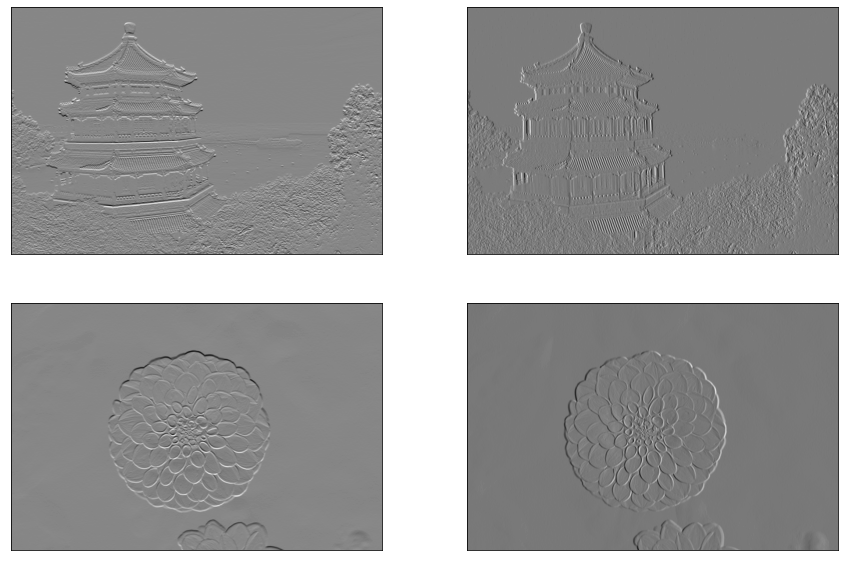

In [ ]:
outputs = tf.nn.conv2d(images, filters, strides=1, padding='VALID')
print(outputs.shape)

plt.figure(figsize=(15,10))
for i in (0,1):
    for j in (0,1):
        plt.subplot(2,2,2*i+j+1)
        plt.imshow(outputs[i,:,:,j], cmap='gray')
        plt.xticks([])
        plt.yticks([])
plt.show()

**[실습2] (15분) (i) 50$\times$50 해상도의 위쪽 절반은 흰색, 아래쪽 절반은 검정색인 흑백이미지를 만들어 출력하시오. 마찬가지로 왼쪽 절반은 흰색, 오른쪽 절반은 검정색인 흑백이미지를 만들어 출력하시오.**

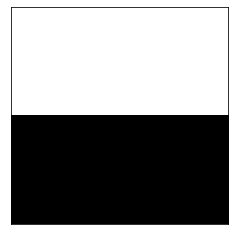

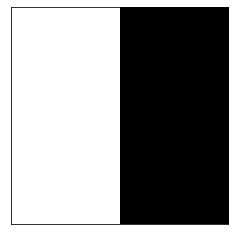

In [ ]:
horizontal = np.zeros((50,50))
horizontal[:25,:] = 1

plt.imshow(horizontal, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

vertical = np.zeros((50,50))
vertical[:,:25] = 1

plt.imshow(vertical, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

**(ii) 두 이미지를 묶은후 1채널을 끼워 넣어 N$\times$H$\times$W$\times$C 포맷으로 만드시오. shape을 출력하시오.**

In [ ]:
images_hv = np.array([horizontal,vertical])
images_hv = images_hv[:,:,:,np.newaxis]
print(images_hv.shape)

(2, 50, 50, 1)


**(iii) 수평 Sobel 필터와 수직 Sobel 필터를 묶고 1채널을 끼워 넣어 FH$\times$FW$\times$C$\times$FN 포맷으로 만드시오. shape을 출력하시오.**

In [ ]:
filter_h_1 = [[1.,2.,1.],[0.,0.,0.],[-1.,-2.,-1.]]
filter_v_1 = [[1.,0.,-1.],[2.,0.,-2.],[1.,0.,-1.]]
filters_1 = np.array([filter_h_1, filter_v_1])
filters_1 = filters_1.transpose(1,2,0)
filters_1 = filters_1[:,:,np.newaxis,:]
print(filters_1.shape)

(3, 3, 1, 2)


**(iv) strides=1, padding='VALID'로 합성곱을 하고 이미지를 2$\times$2 모아찍기로 출력하시오.**

(2, 48, 48, 2)


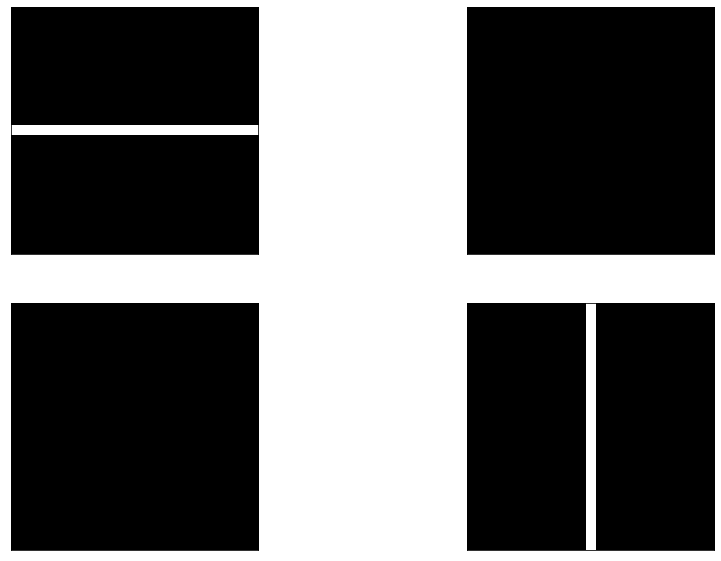

In [ ]:
outputs = tf.nn.conv2d(images_hv, filters_1, strides=1, padding='VALID')
print(outputs.shape)

plt.figure(figsize=(15,10))
for i in (0,1):
    for j in (0,1):
        plt.subplot(2,2,2*i+j+1)
        plt.imshow(outputs[i,:,:,j], cmap='gray')
        plt.xticks([])
        plt.yticks([])
plt.show()

**[과제1] (i) 오른쪽은 RGB 색상표이다. 30$\times$30 해상도의 왼쪽 이미지를 만들어 출력하시오. (오른쪽 위 색깔은 Fuchsia)**  
![](https://drive.google.com/thumbnail?id=1aAGgDTvXwXyLaS_TUo4WNcoD1m4dTB5S&sz=s4000)

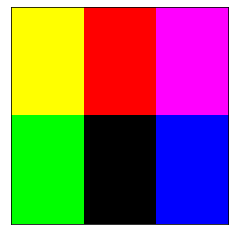

In [ ]:
img = np.zeros((30,30,3))
img[:15,:,0] = 1
img[:,:10,1] = 1
img[:,20:,2] = 1

plt.xticks([])
plt.yticks([])
plt.imshow(img)
plt.show()

**(ii) 수직 Sobel 필터, 수직 Sobel 필터, 수평 Sobel 필터 순으로 RGB 채널로 묶고 FH$\times$FW$\times$C$\times$FN=3$\times$3$\times$3$\times$1 포맷으로 만드시오. shape을 출력하시오.**

In [ ]:
filters = np.array([[filter_v,filter_v,filter_h]])
filters = filters.transpose(2,3,1,0)
print(filters.shape)

(3, 3, 3, 1)


**(iii) strides=1, padding='VALID'로 합성곱을 하고 이미지를 출력하시오.**

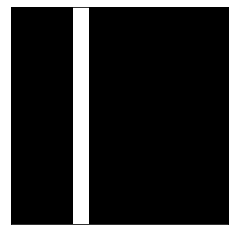

In [ ]:
img = img[np.newaxis,:,:,:]
outputs = tf.nn.conv2d(img, filters, strides=1, padding='VALID')
plt.imshow(outputs[0], cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

**(iv) 위와 같은 이미지가 출력되는 이유를 설명하시오.**

필터가 레드 채널에서는 수직선, 그린 채널에서는 수직선, 블루 채널에서는 수평선을 탐지 합니다.  
레드 채널은 중앙 수평 경계선, 그린 채널은 왼쪽 수직 경계선, 블루 채널은 오른쪽 수직 경계선이 있습니다.  
따라서 필터는 그린채널에서만 왼쪽 수직 경계선을 탐지해냅니다.

# max pooling

우리는 max pooling을 공부했습니다.  
max pooling층 역시 함수 [tf.nn.max_pool2d](https://www.tensorflow.org/api_docs/python/tf/nn/max_pool2d)와 클래스 [tf.keras.layers.MaxPool2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D)로 구현되어 있습니다.  
실험을 위해 tf.nn.max_pool2d를 먼저 사용하겠습니다.  
ksize는 필터의 크기를 말합니다.  
filter의 또다른 이름이 kernel입니다.  
해상도는 3분의 1로 줄어듭니다.  
![](https://drive.google.com/thumbnail?id=1XkRiVEJKGq2IO93EZLfTTJ3l0h_Gxz6u&sz=s4000)

(2, 142, 213, 3)


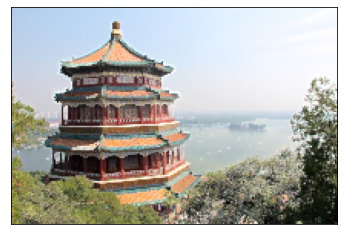

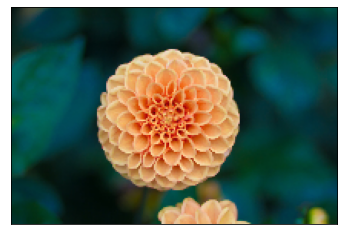

In [ ]:
outputs = tf.nn.max_pool2d(images, ksize=3, strides=3, padding='VALID')
print(outputs.shape)

for i in (0,1):
    plt.imshow(outputs[i,:,:,:])
    plt.xticks([])
    plt.yticks([])
    plt.show()

해상도를 5분의 1로 줄였습니다.

(2, 85, 128, 3)


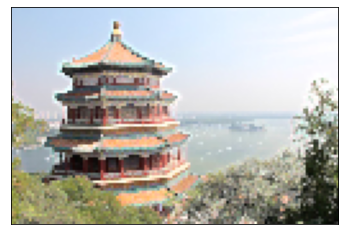

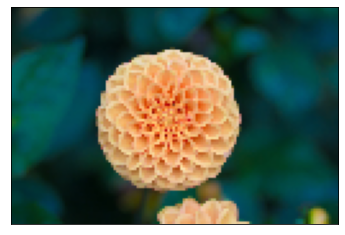

In [ ]:
outputs = tf.nn.max_pool2d(images, ksize=5, strides=5, padding='VALID')
print(outputs.shape)

for i in (0,1):
    plt.imshow(outputs[i,:,:,:])
    plt.xticks([])
    plt.yticks([])
    plt.show()

# 합성곱층과 max pooling층

클래스 [tf.keras.layers.Conv2d](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)와 [tf.keras.layers.MaxPool2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D)로 합성곱층 인스턴스와 max pooling층 인스턴스를 만들겠습니다.  
- filters=9, kernel_size=3 : 3$\times$3 필터를 랜덤하게 총 9개를 만듭니다.
- activation='relu' : 합성곱층 다음에 relu층을 끼워넣습니다. 통상적으로 합성곱층 - relu층 - max pooling층이 하나의 마디를 이룹니다.  
- pool_size=2 : 풀링 필터를 2$\times$2로 잡습니다. 스트라이드를 지정하지 않으면 풀링 필터 사이즈와 동일해집니다.

In [ ]:
from tensorflow import keras
from keras.layers import Conv2D, MaxPool2D

output = Conv2D(filters=9, kernel_size=3, strides=1, padding='same',
                activation='relu')(images)
output = MaxPool2D(pool_size=2)(output)

print(output.shape)

(2, 213, 320, 9)


9개의 필터는 입력 이미지로부터 9개의 특징을 찾아냅니다.  
현재는 랜덤하게 만든 필터이기 때문에 제대로 된 특징을 찾지 못합니다.  
합성곱 신경망에서는 필터가 학습해야할 파라미터입니다.  
학습이 끝난 필터는 입력 이미지의 중요한 특징을 찾아냅니다.  
max pooling층은 해상도를 절반으로 낮춥니다.

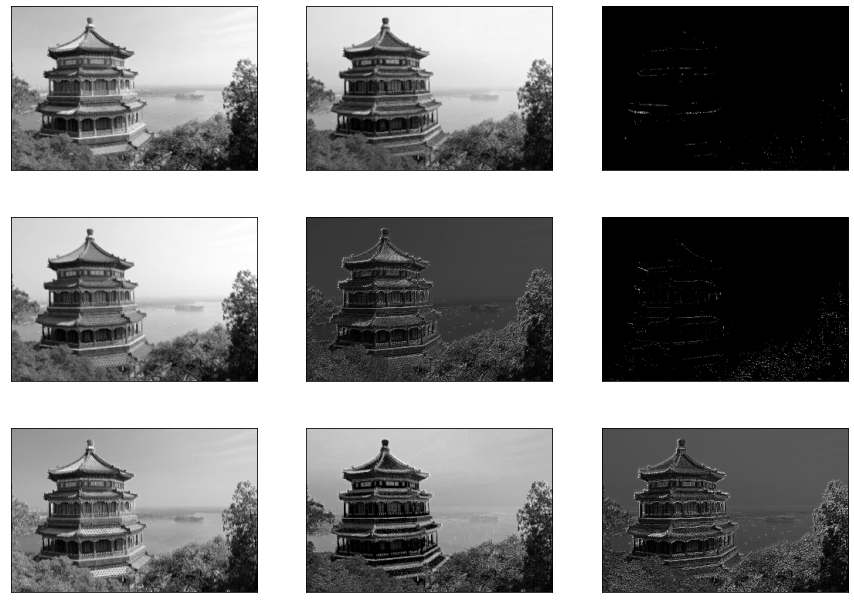

In [ ]:
plt.figure(figsize=(15,11))

for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(output[0,:,:,i],cmap='gray')
plt.show()

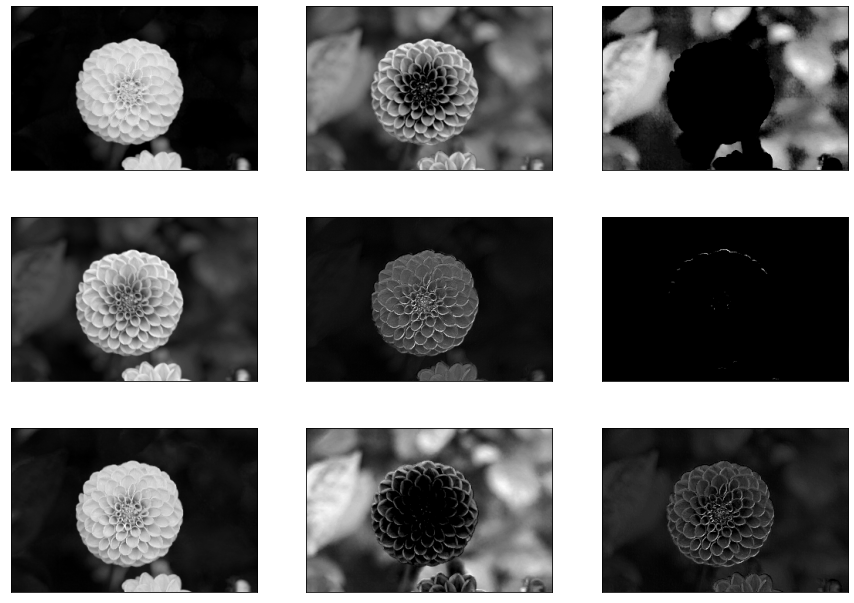

In [ ]:
plt.figure(figsize=(15,11))

for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(output[1,:,:,i],cmap='gray')
plt.show()

# 합성곱 신경망 (CNN)

우리는 합성곱 신경망을 공부했습니다.  
기본적인 합성곱 신경망은 합성곱층 - relu층 - max pooling층 싸이클이 반복되다가 마지막에 Affine층 - softmax층으로 끝납니다.  
Affine층 직전에 [tf.keras.Layers.Flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten)에서 4차원 텐서를 2차원 행렬로 flatten합니다.  
![](https://drive.google.com/thumbnail?id=1ro3QdAEsasDKcqIBQsDMFohMNPNaEjxa&sz=s4000)

---
각층의 역할을 다음과 같습니다.  
- 합성곱층 : 필터들이 움직이면서 이미지의 로컬한 특징들을 찾아냅니다. 저층은 단순한 특징들, 고층은 복잡한 특징을 찾습니다.
- max pooling층 : 필터들이 저층은 더 로컬하게 고층은 더 글로벌하게 커버하도록 합니다.
- fully connected층 : 분류합니다.  
![](https://drive.google.com/thumbnail?id=1F17iO4ENSrvdMD7vn7Q0gT7wmCXVk64I&sz=s4000)

In [ ]:
from keras.layers import Flatten, Dense

def build_model(input_shape, num_out):
    inputs = keras.Input(shape=input_shape)
    x = Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
    x = MaxPool2D(pool_size=2)(x)
    x = Conv2D(filters=64, kernel_size=3, activation="relu")(x)
    x = MaxPool2D(pool_size=2)(x)
    x = Conv2D(filters=128, kernel_size=3, activation="relu")(x)
    x = Flatten()(x)
    outputs = Dense(num_out, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer="rmsprop",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

    return model

model = build_model((28,28,1),10)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 3, 3, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │          11,530 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 104,202 (407.04 KB)

 Trainable params: 104,202 (407.04 KB)

 Non-trainable params: 0 (0.00 B)

MNIST, Fashion MNIST, CIFAR10 데이터셋으로 차례로 합성곱 신경망을 훈련 시켜보겠습니다.  
학습할때마다 달라지만 1강과 비교해서 대략 다음과 같은 성능향상이 있습니다.
- MNIST : 98.0% → 99.3%
- Fashion MNIST : 86.7% → 90.1%
- CIFAR10 : 46.0% → 71.0%

In [ ]:
from tensorflow.keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images[:,:,:,np.newaxis]
train_images = train_images.astype("float32") / 255
test_images = test_images[:,:,:,np.newaxis]
test_images = test_images.astype("float32") / 255

model = build_model(train_images.shape[1:],10)
model.fit(train_images, train_labels, epochs=5, batch_size=64)

test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"\n테스트 정확도: {test_acc:.3f}")

Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.8793 - loss: 0.3815
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9855 - loss: 0.0484
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9903 - loss: 0.0306
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9925 - loss: 0.0240
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9948 - loss: 0.0170
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9871 - loss: 0.0353

테스트 정확도: 0.990


In [ ]:
from keras.datasets import fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_images = train_images[:,:,:,np.newaxis]
train_images = train_images.astype("float32") / 255
test_images = test_images[:,:,:,np.newaxis]
test_images = test_images.astype("float32") / 255

model = build_model(train_images.shape[1:],10)
model.fit(train_images, train_labels, epochs=5, batch_size=64)

test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"\n테스트 정확도: {test_acc:.3f}")

Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.7306 - loss: 0.7319
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8767 - loss: 0.3364
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8945 - loss: 0.2874
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9087 - loss: 0.2503
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9181 - loss: 0.2234
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8879 - loss: 0.3145

테스트 정확도: 0.892


In [ ]:
from keras.datasets import cifar10

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
train_images = train_images.astype("float32") / 255
test_images = test_images.astype("float32") / 255

model = build_model(train_images.shape[1:],10)
model.fit(train_images, train_labels, epochs=10, batch_size=64)

test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"\n테스트 정확도: {test_acc:.3f}")

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.3296 - loss: 1.8359
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.5520 - loss: 1.2742
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.6223 - loss: 1.0724
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.6773 - loss: 0.9428
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.7136 - loss: 0.8366
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.7403 - loss: 0.7588
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.7612 - loss: 0.6940
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.7813 - loss: 0.6282
Epoch 9/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.7996 - loss: 0.5867
Epoch 10/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8186 - loss: 0.5278
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7286 - loss: 0.8539

테스트 정확도: 0.716


**[과제2] (i) $3 \times 3$ 행렬
$$
\begin{pmatrix}
0&1&0\\
1&-4&1\\
0&1&0
\end{pmatrix},
\qquad\qquad
{1 \over 9}
\begin{pmatrix}
1&1&1\\
1&1&1\\
1&1&1
\end{pmatrix}
$$
을 각각 Laplace 필터, Blur 필터라 한다.
Laplace 필터와 Blur 필터를 묶고 1채널을 끼워 넣어 FH$\times$FW$\times$C$\times$FN 포맷으로 만드시오. shape을 출력하시오.**

In [ ]:
filter_L = [[0.,1.,0.],[1.,-4.,1.],[0.,1.,0.]]
filter_b = 1/9*np.array([[1.,1.,1.],[1.,1.,1.],[1.,1.,1.]])
filters_1 = np.array([filter_L,filter_b])
filters_1 = filters_1.transpose(1,2,0)
filters_1 = filters_1[:,:,np.newaxis,:]
print(filters_1.shape)

(3, 3, 1, 2)


**(ii) 실습2에서 만든 데이터에 strides=1, padding='VALID'로 합성곱을 하고 이미지를 2$\times$2 모아찍기로 출력하시오.**

(2, 48, 48, 2)


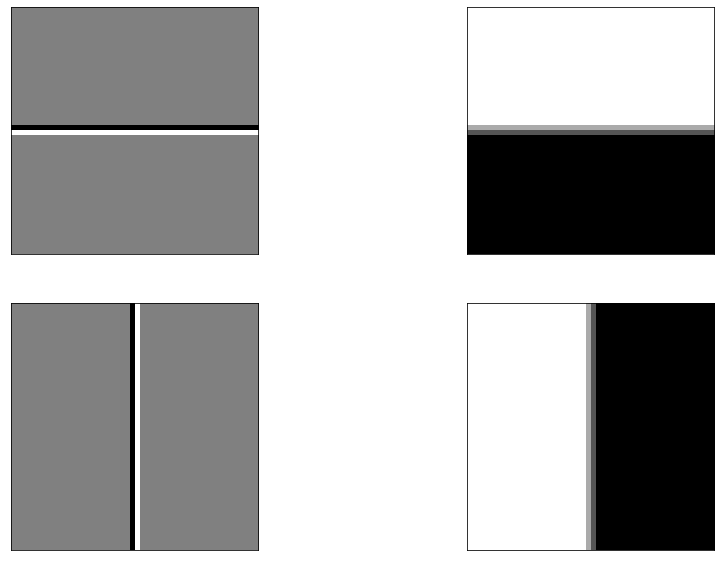

In [ ]:
outputs = tf.nn.conv2d(images_hv, filters_1, strides=1, padding='VALID')
print(outputs.shape)

plt.figure(figsize=(15,10))
for i in (0,1):
    for j in (0,1):
        plt.subplot(2,2,2*i+j+1)
        plt.imshow(outputs[i,:,:,j], cmap='gray')
        plt.xticks([])
        plt.yticks([])
plt.show()

**(iii) Laplace 필터 3개와 Blur 필터 3개를 각각 묶은 후 두 묶음을 다시 묶으시오. 텐서플로우의 필터 포맷인 FH$\times$FW$\times$C$\times$FN으로 축의 위치를 바꿔주시오. shape을 출력하시오.**

In [ ]:
filters_L = np.array([filter_L,filter_L,filter_L])
filters_b = np.array([filter_b,filter_b,filter_b])

filters = np.array([filters_L, filters_b])
filters = filters.transpose(2,3,1,0)

print(filters.shape)

(3, 3, 3, 2)


**(iv) 불향각 사진과 데이지 사진에 스트라이드 1, 노 패딩으로 합성곱을 하시오. 행은 N, 열은 FN인 2$\times$2 바둑판 형태로 출력하시오.**

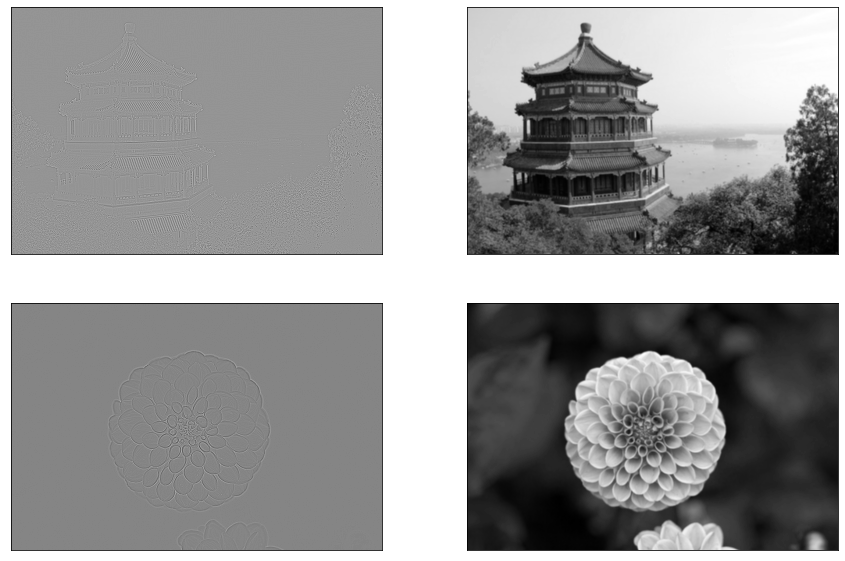

In [ ]:
outputs = tf.nn.conv2d(images, filters, strides=1, padding='VALID')

plt.figure(figsize=(15,10))
for i in (0,1):
    for j in (0,1):
        plt.subplot(2,2,2*i+j+1)
        plt.imshow(outputs[i,:,:,j], cmap='gray')
        plt.xticks([])
        plt.yticks([])
plt.show()

**[과제3] (i) 오른쪽은 RGB 색상표이다. 왼쪽 30$\times$30 해상도 이미지가 출력되도록 코드를 작성하시오. (왼쪽 중간 색깔은 Fuchsia)**

![](https://drive.google.com/thumbnail?id=1ZhnzVXNihBqMyrG-bQdaPvzPF1GaVl5X&sz=s4000)

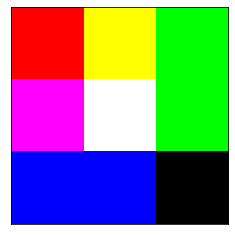

In [ ]:
img = np.zeros((30,30,3))
img[:20,:20,0] = 1
img[:20,10:,1] = 1
img[10:,:20,2] = 1

plt.xticks([])
plt.yticks([])
plt.imshow(img)
plt.show()

**(ii) RGB 채널을 각각 뽑아내는 세 개의 $3\times3$ 필터를 만드시오. 해상도가 줄이들지 않도록 설정한후 위 컬러 이미지에 합성곱한 이미지를 출력하시오.**

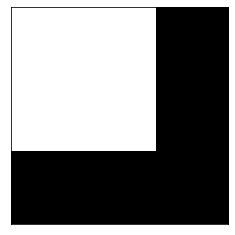

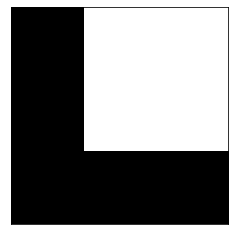

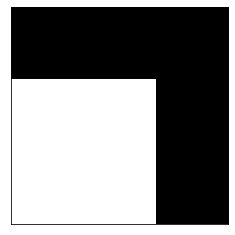

In [ ]:
img = img.reshape(1,30,30,3)

filters = np.zeros((3,3,3,3))
for i in range(3):
    filters[1,1,i,i]=1

outputs = tf.nn.conv2d(img, filters, strides=1, padding='SAME')

for i in range(3):
    plt.imshow(outputs[0,:,:,i], cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()